In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import stim
import pymatching

# Code parameters
d=3
T=3
layout = [25, 19, 26, 22, 16] # Hardcoded for testing purposes, can be retrieved


circuit = stim.Circuit.generated("repetition_code:memory",
                                 distance=d,
                                 rounds=T,
                                 after_clifford_depolarization=0.1)

model = circuit.detector_error_model(decompose_errors=True)
matching = pymatching.Matching.from_detector_error_model(model)

#draw_matching_graph(matching, d, T)

In [3]:
from result_saver import SaverProvider
from soft_info import get_counts, get_KDEs
provider = SaverProvider()


job = provider.retrieve_job("cmyhbrqrmwhg008bs4h0")
memory = job.result().get_memory()

kde_dict, scaler_dict = get_KDEs(provider, 'ibmq_mumbai', layout, bandwidths=0.2, plot=False)


  0%|          | 0/2 [00:00<?, ?it/s]

Count key: 010 10 00 00
count str to syndromes: [0 0 0 0 0 1 1 0]
matched_edges:  [[7 5]
 [7 6]]
Estimated flip: [0]


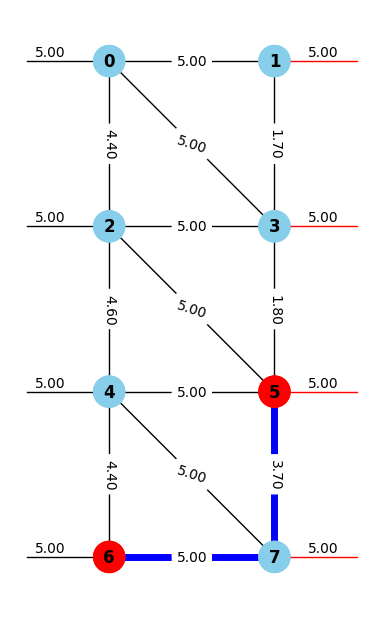

 50%|█████     | 1/2 [00:00<00:00,  5.41it/s]

Count key: 000 10 10 10
count str to syndromes: [0 1 0 0 0 0 0 1]
matched_edges:  [[ 1 -1]
 [ 7 -1]]
Estimated flip: [0]


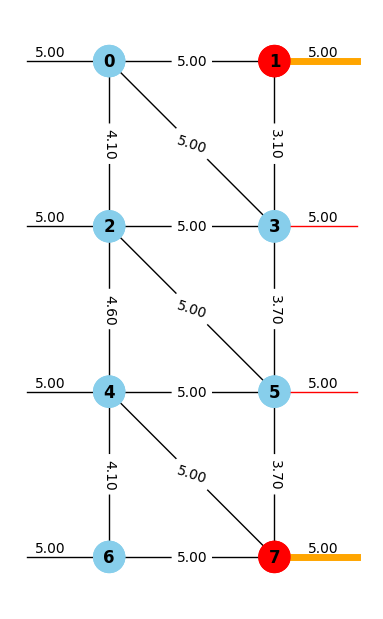

100%|██████████| 2/2 [00:00<00:00,  5.48it/s]

Num errors: 0


In [18]:
from tqdm import tqdm

from soft_info import counts_to_det_syndr, reweight_edges_to_one, soft_reweight_pymatching, draw_matching_graph

VERBOSE = True

actual_observables = np.array([[False]]) # hardcoded, can be retrieved
num_errors = 0

i = 0
w_idx_lst = []
for shot in tqdm(range(len(memory))[754:756]):
    i += 1
    IQ_data = memory[shot]

    counts = get_counts([IQ_data], kde_dict, scaler_dict, layout, T, verbose=False)
    count_key = next(iter(counts.keys()))

    if count_key == '000 00 00 00':
        #print("Skipping all zeros")
        continue    

    soft_reweight_pymatching(matching, d, T, IQ_data, kde_dict, layout, scaler_dict, common_measure=0.1, verbose=False)  
    #reweight_edges_to_one(matching)

    array_processed_string = counts_to_det_syndr(count_key, verbose=False)

    predicted_observables = matching.decode(array_processed_string)



    #if predicted_observables == [0]:
        #continue
    
    #print(f"Wrong decoding at index {i}")
    w_idx_lst.append(i)

    
    if VERBOSE:
        print("Count key:", count_key)
        print("count str to syndromes:", array_processed_string)


    if VERBOSE:
        matched_edges = matching.decode_to_edges_array(array_processed_string)
        print("matched_edges: ", matched_edges)
        print("Estimated flip:", predicted_observables)
    

    if VERBOSE:
        draw_matching_graph(matching, d, T, syndromes=array_processed_string, matched_edges=matched_edges, figsize=(6, 6))

    num_errors += not np.array_equal(actual_observables[0, :], predicted_observables) # 0 can be changed to i if multiple observables and multiple syndromes per ovbservable

print("Num errors:", num_errors)


  0%|          | 0/2 [00:00<?, ?it/s]

Count key: 010 10 00 00
count str to syndromes: [0 0 0 0 0 1 1 0]
matched_edges:  [[ 5 -1]
 [ 6 -1]]
Estimated flip: [1]


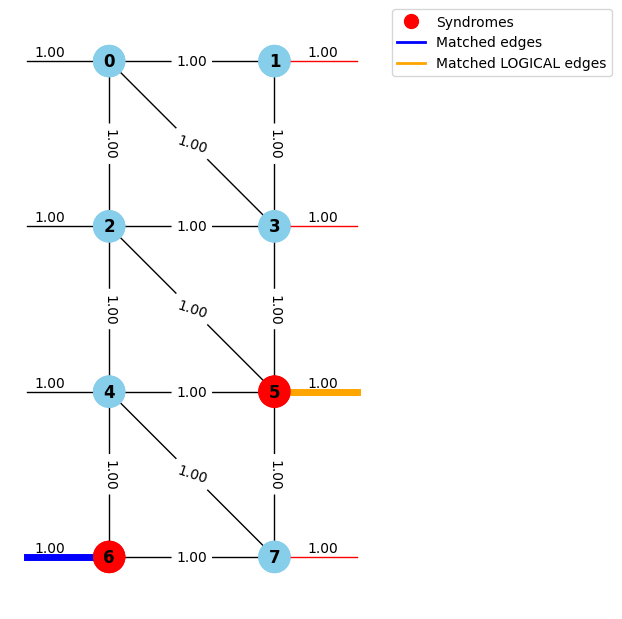

100%|██████████| 2/2 [00:00<00:00, 10.38it/s]

Num errors: 1


In [28]:
from tqdm import tqdm

from soft_info import counts_to_det_syndr, reweight_edges_to_one, soft_reweight_pymatching, draw_matching_graph

VERBOSE = True

actual_observables = np.array([[False]]) # hardcoded, can be retrieved
num_errors = 0

i = 0
nw_idx_lst = []
for shot in tqdm(range(len(memory))[754:756]):
    i += 1
    IQ_data = memory[shot]

    counts = get_counts([IQ_data], kde_dict, scaler_dict, layout, T, verbose=False)
    count_key = next(iter(counts.keys()))

    if count_key == '000 00 00 00':
        #print("Skipping all zeros")
        continue    

    #soft_reweight_pymatching(matching, d, T, IQ_data, kde_dict, layout, scaler_dict, common_measure=0.1, verbose=False)  
    reweight_edges_to_one(matching)

    array_processed_string = counts_to_det_syndr(count_key, verbose=False)

    predicted_observables = matching.decode(array_processed_string)



    if predicted_observables == [0]:
        continue
    
    #print(f"Wrong decoding at index {i}")
    nw_idx_lst.append(i)

    
    if VERBOSE:
        print("Count key:", count_key)
        print("count str to syndromes:", array_processed_string)


    if VERBOSE:
        matched_edges = matching.decode_to_edges_array(array_processed_string)
        print("matched_edges: ", matched_edges)
        print("Estimated flip:", predicted_observables)
    

    if VERBOSE:
        draw_matching_graph(matching, d, T, syndromes=array_processed_string, matched_edges=matched_edges, figsize=(6, 6))

    num_errors += not np.array_equal(actual_observables[0, :], predicted_observables) # 0 can be changed to i if multiple observables and multiple syndromes per ovbservable

print("Num errors:", num_errors)


In [15]:
# find the indices that are just in one list
w_idx_lst = set(w_idx_lst)
nw_idx_lst = set(nw_idx_lst)
unique_idx_list = list(w_idx_lst.symmetric_difference(nw_idx_lst))

print("Different wrong indices:", unique_idx_list)
print("w_idx_lst:", w_idx_lst)
print("nw_idx_lst:", nw_idx_lst)

Different wrong indices: [755]
w_idx_lst: {262, 263, 136, 264, 519, 780, 656, 657, 802, 420, 549, 295, 682, 687, 943, 949, 952, 60, 831, 962, 579, 453, 846, 737, 488, 502}
nw_idx_lst: {262, 263, 136, 264, 519, 780, 656, 657, 802, 420, 549, 295, 682, 687, 943, 949, 952, 60, 831, 962, 579, 453, 846, 737, 488, 755, 502}
